# How to install RDKit from source

RDKit is a bit open source chemistry-informatics library, written in C++, but with Python wrappers and good Python support. The annoying thing is that you can't use `pip install rdkit` or anything like that. Instead, the offical way is to use conda. I didn't really want to do that, and I also didn't really want to install Boost (another big C++ library) in the `/usr/whatever` directory of my laptop, only to be used once ever, so I thought I would try to install it from source on my machine (I'm using Ubuntu 20.04). 

Probably I should have just done it the 'offical' way to save myself a lot of pain but anyway, if you want to do the same as me, here is some probably unhelpful help:

### Environment variables

```
export RDBASE=/home/will/Desktop/projects/ocsr_comp/external/src/rdkit-Release_2020_09_5
export BOOST=/home/will/Desktop/projects/ocsr_comp/external/build/boost
export LD_LIBRARY_PATH=/usr/local/cuda-10.1/lib64:$RDBASE/lib:$BOOST/lib
export PYTHONPATH=$PYTHONPATH:$RDBASE
```

### Here's some other crap that I had to do

To install Boost I used the following magic words:

```
./bootstrap.sh --prefix=/home/will/Desktop/projects/ocsr_comp/external/build/boost --with-libraries=all
```

**I also had to edit the file `project-config.jam` at line 21 with this:**

```
if ! [ python.configured ]
{
    using python : 3.8 : /usr/include/python3.8 : /usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so ;
}
```

Then followed by `./b2 install`

I also had to install cairo, but I did that through apt-get since it wasn't huge (23MB), rather than trying to do it from source too. 

### Installing RDKit

This was a bit of a pain too, I ran 

```

cmake \
    -DBOOST_ROOT=/home/will/Desktop/projects/ocsr_comp/external/build/boost \
    -D PYTHON_LIBRARY=/usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so \
    -D PYTHON_INCLUDE_DIR=/usr/include/python3.8 \
    -DRDK_BUILD_INCHI_SUPPORT=ON \
    -DRDK_BUILD_AVALON_SUPPORT=ON \
    -DRDK_BUILD_CAIRO_SUPPORT=ON \
    -DBoost_USE_STATIC_LIBS=OFF ..

```
followed by 

```

make 
make install
ctest
```

One of the tests failed but I pasted the message into google and a whole bunch of people have had the same problem, so I think it is actually a bad test case rather than a compilation error. 

### Making life a bit easier

I added a bit of code into my `./venv/bin/activate` script so that I wouldn't always have to do this:

```
if [ -z "$RDBASE" ] ; then
    export RDBASE=/home/will/Desktop/projects/ocsr_comp/external/src/rdkit-Release_2020_09_5
    export BOOST=/home/will/Desktop/projects/ocsr_comp/external/build/boost
    export LD_LIBRARY_PATH=/usr/local/cuda-10.1/lib64:$RDBASE/lib:$BOOST/lib
    export PYTHONPATH=$PYTHONPATH:$RDBASE
fi
```

### Compiler Errors and stuff that went wrong

The fact that I don't really know what I am doing at all with C++, make, cmake, bash, Linux, and computers in general made this a lot harder than it should have been. Here are some of the resources that I used:

- [rkdit instructions](https://www.rdkit.org/docs/Install.html])
- [boost instructions](https://www.boost.org/doc/libs/1_75_0/more/getting_started/unix-variants.html)
- Some general stackoverflow faffing

In retrospect there wasn't anything particularly hard to do, but it still took me absolutely ages. Here is some stuff I noticed:

I got a lot of errors when trying to build rdkit about 'could not find Boost', or 'could not find Boost (python)'. Building Boost when pointing at the correct python headers required tracking down where the compiled python libraries are, which led to changing the project-config.jam file for Boost (whatever the hell that is). 

I ended up editing this into the file at the appropriate place (courtesy of another stackoverflow post):

```
using python : 3.8 : /usr/include/python3.8 : /usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so
```

These use the full path to my python include directory and the full path to the python static library ([here's](https://stackoverflow.com/questions/12293530/what-is-the-difference-between-so-and-a-files/12293619) a description of what this is). 

The LD_LIBRARY_PATH really needs the $BOOST/lib in it; also it is super important to make sure your environment variables are set correctly. Both Boost and RDKit take quite a long time to compile. 

All of the CMake options are also kind of a faff... all of them are pretty necessary and it isn't super obvious in the instructions (though the advice is all there if you read carefully). 

### Does it work?

After all that pain it is worth trying to see if the thing actually works or not:

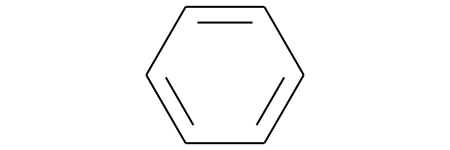

In [4]:
from rdkit import Chem

mol = Chem.MolFromSmiles('c1ccccc1')
mol

**Finally!**
This works (even in a different virtual environment) as long as RDBASE, LD_LIBRARY_PATH, and PYTHONPATH (and BOOST) are all set as environment variables. 